In [125]:
import cv2
import numpy as np
import math
import os
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt
from matplotlib.widgets import RectangleSelector
import random
from mpl_toolkits.mplot3d import Axes3D

In [126]:
color_selection_path = r"\\10.99.134.183\kiemen-lab-data\Yu Shen\T1D\tiles4hsv\t1d_ihcBandC"
images_to_process = r"\\10.99.134.183\kiemen-lab-data\Yu Shen\T1D\6516_none\10x"
#images_to_process = r"\\10.99.134.183\kiemen-lab-data\Yu Shen\T1D\tiles4hsv\ND_ihcBandC"
processed_images_path = r"\\10.99.134.183\kiemen-lab-data\Yu Shen\T1D\6516_none\10x\ben_ihc_immune_and_vessel"
#processed_images_path = r"\\10.99.134.183\kiemen-lab-data\Yu Shen\T1D\tiles4hsv\ND_ihcBandC"
downscale_factor = 8 #only for tile creation
tile_size = 200
mask_output_type = ".jpg"
file_type = ".jpg"
mosaic_image_nums = 9

In [127]:
import cv2
import numpy as np
import os
import random
from os.path import isfile, join

# Global variables
drawing = False
ix, iy = -1, -1
mask = None  # Initialize mask
save_rectangle = False

zoom_factor = 1.0
pan_x, pan_y = 0, 0
cursor_x, cursor_y = 0, 0
mouseRGB_last_x = 0
mouseRGB_last_y = 0
coordinates = []

# Downscale factor for display (adjust as needed for performance)
downscale_factor_display = 1  # 10% of the original size

def clamp(val, min_val, max_val):
    """Clamp value within the specified min and max bounds."""
    return max(min_val, min(val, max_val))

def mouseRGB(event, x, y, flags, param):
    global zoom_factor, pan_x, pan_y, cursor_x, cursor_y, drawing, mouseRGB_last_x, mouseRGB_last_y, display_img, img_display, downscale_factor_display, coordinates

    if event == cv2.EVENT_LBUTTONDOWN:
        mouseRGB_last_x, mouseRGB_last_y = x, y

    elif event == cv2.EVENT_RBUTTONDOWN:
        edge_len = tile_size * downscale_factor_display
        click_center_x, click_center_y = x, y

        M = np.float32([[zoom_factor, 0, cursor_x - cursor_x * zoom_factor + pan_x], 
                        [0, zoom_factor, cursor_y - cursor_y * zoom_factor + pan_y]])
        inv_M = cv2.invertAffineTransform(M)
        orig_center = cv2.transform(np.array([[[click_center_x, click_center_y]]]), inv_M)[0][0]

        orig_top_left = (int(orig_center[0] - edge_len // 2), int(orig_center[1] - edge_len // 2))
        orig_bottom_right = (int(orig_center[0] + edge_len // 2), int(orig_center[1] + edge_len // 2))

        # Clamp coordinates to the image dimensions
        orig_top_left = (clamp(orig_top_left[0], 0, img_display.shape[1] - 1),
                         clamp(orig_top_left[1], 0, img_display.shape[0] - 1))
        orig_bottom_right = (clamp(orig_bottom_right[0], 0, img_display.shape[1] - 1),
                             clamp(orig_bottom_right[1], 0, img_display.shape[0] - 1))

        cv2.rectangle(img_display, orig_top_left, orig_bottom_right, (0, 0, 255), 2)
        coordinates.append([orig_top_left[0], orig_top_left[1], orig_bottom_right[0], orig_bottom_right[1]])
        update_display_img()

    elif event == cv2.EVENT_MOUSEWHEEL:
        cursor_x, cursor_y = x, y
        zoom_factor += 0.1 if flags > 0 else -0.1
        zoom_factor = max(0.1, zoom_factor)
        update_display_img()

    elif event == cv2.EVENT_MOUSEMOVE:
        if flags & cv2.EVENT_FLAG_LBUTTON:
            pan_x += x - mouseRGB_last_x
            pan_y += y - mouseRGB_last_y
            mouseRGB_last_x, mouseRGB_last_y = x, y
            update_display_img()

def update_display_img():
    global display_img, zoom_factor, pan_x, pan_y, cursor_x, cursor_y, img_display
    h, w = img_display.shape[:2]
    center_x, center_y = cursor_x, cursor_y
    M = np.float32([[zoom_factor, 0, center_x - center_x * zoom_factor + pan_x],
                    [0, zoom_factor, center_y - center_y * zoom_factor + pan_y]])
    display_img = cv2.warpAffine(img_display, M, (w, h))
    cv2.imshow('image', display_img)

# Load images from the directory
mypath = color_selection_path

#Change this to modify the postfix of the image loaded 
onlyfiles = [f for f in os.listdir(mypath) if isfile(join(mypath, f))]


# Randomly select files
#if len(onlyfiles) > mosaic_image_nums:
    #selected_files = random.sample(onlyfiles, mosaic_image_nums)
#else:
    #selected_files = onlyfiles
# Repeat files if we don't have enough images to meet mosaic_image_nums
if len(onlyfiles) == 0:
    print("No files found with 'vessel' in the name.")
    selected_files = []
elif len(onlyfiles) < mosaic_image_nums:
    # If we have fewer files than required, repeat the list to reach the desired count
    selected_files = (onlyfiles * (mosaic_image_nums // len(onlyfiles) + 1))[:mosaic_image_nums]
else:
    # If we have enough files, select the first `mosaic_image_nums` files
    selected_files = onlyfiles[:mosaic_image_nums]

images = []


for read_path in selected_files:
    final_path = join(mypath, read_path)
    print(f"Processing {final_path}")  # Debugging line to print the file path being processed

    # Load only a downscaled version for display
    img_full = cv2.imread(final_path, cv2.IMREAD_COLOR)
    if img_full is None:
        print(f"Failed to load image at {final_path}")
        continue

    # Create a downscaled version for display
    img_display = cv2.resize(
        img_full, 
        (int(img_full.shape[1] * downscale_factor_display), 
         int(img_full.shape[0] * downscale_factor_display)), 
        interpolation=cv2.INTER_LINEAR
    )

    display_img = None
    coordinates = []

    cv2.imshow('image', img_display)
    cv2.setMouseCallback('image', mouseRGB)

    # Wait for ESC key to exit or 'x' to save rectangles
    while True:
        key = cv2.waitKey(20) & 0xFF
        if key == 27:  # ESC key
            break
        elif key == ord('x'):
            save_rectangle = True  # Change color to blue

    # Process rectangles and save cropped images
    for coord in coordinates:
        print(f"Cropping coordinates: {coord}")
        # Scale coordinates back to original resolution
        top_left = (int(coord[0] / downscale_factor_display), 
                    int(coord[1] / downscale_factor_display))
        bottom_right = (int(coord[2] / downscale_factor_display), 
                        int(coord[3] / downscale_factor_display))

        # Clamp the coordinates within the original image's dimensions
        top_left = (clamp(top_left[0], 0, img_full.shape[1] - 1),
                    clamp(top_left[1], 0, img_full.shape[0] - 1))
        bottom_right = (clamp(bottom_right[0], 0, img_full.shape[1] - 1),
                        clamp(bottom_right[1], 0, img_full.shape[0] - 1))

        # Crop from the original high-resolution image
        cropped_image = img_full[top_left[1]:bottom_right[1], top_left[0]:bottom_right[0]]
        if cropped_image.size == 0:
            print(f"Warning: Cropped image is empty for coordinates: {coord}")
            continue

        print(f"Cropped image shape: {cropped_image.shape}")
        images.append(cropped_image)

    cv2.destroyAllWindows()


Processing \\10.99.134.183\kiemen-lab-data\Yu Shen\T1D\tiles4hsv\t1d_ihcBandC\6520-044-immune_tile_00001.tif
Cropping coordinates: [75, 49, 275, 249]
Cropped image shape: (200, 200, 3)
Processing \\10.99.134.183\kiemen-lab-data\Yu Shen\T1D\tiles4hsv\t1d_ihcBandC\6520-044-immune_tile_00002.tif
Cropping coordinates: [64, 48, 264, 248]
Cropped image shape: (200, 200, 3)
Processing \\10.99.134.183\kiemen-lab-data\Yu Shen\T1D\tiles4hsv\t1d_ihcBandC\6520-059-vessels_tile_00002.tif
Cropping coordinates: [64, 48, 264, 248]
Cropped image shape: (200, 200, 3)
Processing \\10.99.134.183\kiemen-lab-data\Yu Shen\T1D\tiles4hsv\t1d_ihcBandC\6520-059-vessels_tile_00003.tif
Cropping coordinates: [64, 48, 264, 248]
Cropped image shape: (200, 200, 3)
Processing \\10.99.134.183\kiemen-lab-data\Yu Shen\T1D\tiles4hsv\t1d_ihcBandC\6520-059-vessels_tile_00006.tif
Cropping coordinates: [41, 48, 241, 248]
Cropped image shape: (200, 200, 3)
Processing \\10.99.134.183\kiemen-lab-data\Yu Shen\T1D\tiles4hsv\t1d_ihc

In [128]:
import cv2
import math

def concatenate_images(images, rows, cols):
    """
    Concatenate multiple images of the same size into a grid.
    :param images: List of images to concatenate
    :param rows: Number of rows in the grid
    :param cols: Number of columns in the grid
    :return: Concatenated image
    """
    assert len(images) <= rows * cols, "Number of images is greater than grid size"

    # Ensure all images are the same size
    assert all(img.shape == images[0].shape for img in images), "All images must have the same dimensions"

    # Create rows of images
    rows_of_images = [cv2.hconcat(images[i:i+cols]) for i in range(0, len(images), cols)]

    # Concatenate rows vertically
    return cv2.vconcat(rows_of_images)

def calculate_grid(num_imgs):
    """
    Calculate the number of rows and columns for a grid to display the images
    in a rectangular shape.
    :param num_imgs: Total number of images
    :return: (rows, cols) tuple
    """
    # Initialize rows and columns
    rows = cols = int(math.sqrt(num_imgs))

    # Increase rows or cols to accommodate all images
    while rows * cols < num_imgs:
        if cols <= rows:
            cols += 1
        else:
            rows += 1

    return rows, cols

num_imgs = len(images)

if images:
    y_grid, x_grid = calculate_grid(num_imgs)
    result = concatenate_images(images, y_grid, x_grid)

else:
    print("No images to concatenate.")


In [129]:
# Initialize lists and index
stain_colors = ["brown", "blue", "red"]
hsv_values = [[] for _ in stain_colors]  # List to store HSV values for each color
hsv_index = 0

def set_hsv_index(value):
    global hsv_index
    try:
        hsv_index = int(value)
        if 0 <= hsv_index < len(stain_colors):
            print(f"HSV index set to: {hsv_index} ({stain_colors[hsv_index]})")
        else:
            print(f"Invalid index. Please enter a number between 0 and {len(stain_colors) - 1}.")
    except ValueError:
        print("Invalid input. Please enter a valid number.")

# Function to display the HSV values on mouse click
def get_hsv_values(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN or event == cv2.EVENT_RBUTTONDOWN:
        hsv_value = hsv_image[y, x]
        print(f"Mouse Event: {event}, HSV Value at ({x}, {y}): {hsv_value}")
        if event == cv2.EVENT_RBUTTONDOWN:
            if 0 <= hsv_index < len(stain_colors):
                hsv_values[hsv_index].append(hsv_value)
                print(f"HSV Value added to index {hsv_index}: {hsv_value}")
            else:
                print("Invalid HSV index. Cannot add value.")

# Convert the image to HSV color space
hsv_image = cv2.cvtColor(result, cv2.COLOR_BGR2HSV)

# Create a resizable window and set a mouse callback
cv2.namedWindow('Image', cv2.WINDOW_KEEPRATIO)
cv2.setMouseCallback('Image', get_hsv_values)
input_value = input("Enter a number for HSV index (0 for brown, 1 for blue, 2 for red): ")
set_hsv_index(input_value)

while True:
    cv2.imshow('Image', result)
    key = cv2.waitKey(20) & 0xFF
    if key == 27:  # ESC key to break
        break
    elif key == ord('c'):  # Press 'c' key to change HSV index
        # Ask the user to input the HSV index
        input_value = input("Enter a number for HSV index (0 for brown, 1 for blue, 2 for red): ")
        set_hsv_index(input_value)

cv2.destroyAllWindows()

# Initialize lists to store max and min values for each color category
max_values_list = []
min_values_list = []

# Calculate max and min values separately for each color category
for i in hsv_values:  # Iterating over each color category
    if i:  # Ensure there are values to compute max and min
        max_values = np.amax(i, axis=0).tolist()  # Convert to list for better readability
        min_values = np.amin(i, axis=0).tolist()  # Convert to list for better readability
        max_values_list.append(max_values)
        min_values_list.append(min_values)
    else:
        max_values_list.append([0, 0, 0])  # Default values if no data
        min_values_list.append([0, 0, 0])  # Default values if no data

print("Max values for each color category:", max_values_list)
print("Min values for each color category:", min_values_list)

HSV index set to: 0 (brown)
Max values for each color category: [[0, 0, 0], [0, 0, 0], [0, 0, 0]]
Min values for each color category: [[0, 0, 0], [0, 0, 0], [0, 0, 0]]


In [30]:
# import dash
# from dash import dcc, html
# from dash.dependencies import Input, Output, State
# import plotly.graph_objs as go
# import numpy as np
# import cv2
# import base64
# 
# # Assuming 'result' is your image array
# def generate_image():
#     # Convert thresholds to appropriate dtype
#     live_low_brown = np.array([x_plane_thresholds[0], y_plane_thresholds[0], z_plane_thresholds[0]], dtype=np.uint8)
#     live_high_brown = np.array([x_plane_thresholds[1], y_plane_thresholds[1], z_plane_thresholds[1]], dtype=np.uint8)
#     live_low_blue = np.array([x_plane_thresholds[2], y_plane_thresholds[2], z_plane_thresholds[2]], dtype=np.uint8)
#     live_high_blue = np.array([x_plane_thresholds[3], y_plane_thresholds[3], z_plane_thresholds[3]], dtype=np.uint8)
#     live_low_red = np.array([x_plane_thresholds[4], y_plane_thresholds[4], z_plane_thresholds[4]], dtype=np.uint8)
#     live_high_red = np.array([x_plane_thresholds[5], y_plane_thresholds[5], z_plane_thresholds[5]], dtype=np.uint8)
# 
#     live_hsv = cv2.cvtColor(result, cv2.COLOR_BGR2HSV)
# 
#     # Create masks based on the color ranges
#     live_blue_mask = cv2.inRange(live_hsv, live_low_blue, live_high_blue)
#     live_red_mask = cv2.inRange(live_hsv, live_low_red, live_high_red)
#     live_brown_mask = cv2.inRange(live_hsv, live_low_brown, live_high_brown)
# 
#     # Create a blank image with the same dimensions as the original image
#     live_overlay = np.zeros_like(result)
# 
#     # Assign colors to the overlay based on masks
#     live_overlay[live_brown_mask != 0] = [0, 255, 0]  # Brown mask as green (BGR format)
#     live_overlay[live_blue_mask != 0] = [255, 0, 0]  # Blue mask as red (BGR format)
#     live_overlay[live_red_mask != 0] = [0, 0, 255]  # Red mask as blue (BGR format)
#     
# 
#     # Combine the overlay with the original image
#     live_mask = cv2.addWeighted(result, 0.6, live_overlay, 0.4, 0)
#     return live_mask
# 
# plot_img = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
# 
# # Get image dimensions
# height, width, _ = plot_img.shape
# 
# # Generate points every 5 pixels
# step_size = 5
# x_coords = np.arange(0, width, step_size)
# y_coords = np.arange(0, height, step_size)
# grid_x, grid_y = np.meshgrid(x_coords, y_coords)
# sampled_points = np.column_stack((grid_x.ravel(), grid_y.ravel()))
# 
# # Sample the colors at the points
# colors = plot_img[sampled_points[:, 1], sampled_points[:, 0]]
# normalized_colors = colors / 255
# 
# # Convert RGB to HSV
# def rgb_to_hsv(rgb):
#     return np.array([cv2.cvtColor(np.uint8([[color]]), cv2.COLOR_RGB2HSV)[0][0] for color in rgb])
# 
# hsv_sampled_colors = rgb_to_hsv(colors)
# hsv_sampled_colors = hsv_sampled_colors.astype(float)
# 
# x = hsv_sampled_colors[:, 0]  # Hue
# y = hsv_sampled_colors[:, 1]  # Saturation
# z = hsv_sampled_colors[:, 2]  # Value
# 
# # Initial x, y, z values and color for the draggable plane
# initial_x = 0
# initial_y = 0
# initial_z = 0
# initial_color = '#8B4513'  # Initial color is brown
# x_plane_thresholds = np.zeros(6, np.float32)
# y_plane_thresholds = np.zeros(6, np.float32)
# z_plane_thresholds = np.zeros(6, np.float32)
# 
# # Encode the initial image in base64
# def encode_image(image):
#     _, buffer = cv2.imencode('.png', image)
#     encoded_image = base64.b64encode(buffer).decode('utf-8')
#     return encoded_image
# 
# encoded_image = encode_image(result)
# encoded_static_image = encode_image(result)
# 
# # Create the 3D scatter plot
# scatter = go.Scatter3d(
#     x=x,  # x coordinates (Hue)
#     y=y,  # y coordinates (Saturation)
#     z=z,  # z coordinates (Value)
#     mode='markers',
#     marker=dict(
#         size=5,
#         color=[f'rgb({r}, {g}, {b})' for r, g, b in colors]  # Corrected color format
#     ),
# )
# 
# # Create the Dash app
# app = dash.Dash(__name__)
# 
# def create_plane(value, axis, color):
#     if axis == 'x':
#         return go.Surface(
#             z=[[min(z), min(z)], [max(z), max(z)]],
#             y=[[min(y), max(y)], [min(y), max(y)]],
#             x=[[value, value], [value, value]],
#             opacity=0.5,
#             surfacecolor=[[0, 0], [0, 0]],
#             colorscale=[[0, color], [1, color]],
#             showscale=False
#         )
#     elif axis == 'y':
#         return go.Surface(
#             z=[[min(z), min(z)], [max(z), max(z)]],
#             y=[[value, value], [value, value]],
#             x=[[min(x), max(x)], [min(x), max(x)]],
#             opacity=0.5,
#             surfacecolor=[[0, 0], [0, 0]],
#             colorscale=[[0, color], [1, color]],
#             showscale=False
#         )
#     elif axis == 'z':
#         return go.Surface(
#             x=[[min(x), min(x)], [max(x), max(x)]],
#             y=[[min(y), max(y)], [min(y), max(y)]],
#             z=[[value, value], [value, value]],
#             opacity=0.5,
#             surfacecolor=[[0, 0], [0, 0]],
#             colorscale=[[0, color], [1, color]],
#             showscale=False
#         )
# 
# # Create the initial figure
# fig = go.Figure(data=[
#     scatter,
#     create_plane(initial_x, 'x', initial_color),
#     create_plane(initial_y, 'y', initial_color),
#     create_plane(initial_z, 'z', initial_color)
# ])
# 
# fig.update_layout(
#     scene=dict(
#         xaxis=dict(
#             range=[0, 180],
#             title='Hue',
#             backgroundcolor="white",  # Set the x-axis background color to white
#             gridcolor="black",         # Set the x-axis grid color to black
#             showbackground=True
#         ),
#         yaxis=dict(
#             range=[0, 255],
#             title='Saturation',
#             backgroundcolor="white",  # Set the y-axis background color to white
#             gridcolor="black",         # Set the y-axis grid color to black
#             showbackground=True
#         ),
#         zaxis=dict(
#             range=[0, 255],
#             title='Value',
#             backgroundcolor="white",  # Set the z-axis background color to white
#             gridcolor="black",         # Set the z-axis grid color to black
#             showbackground=True
#         ),
#         bgcolor="white",               # Set the scene background color to white
#         camera=dict(
#             eye=dict(x=1.25, y=1.25, z=1.25)
#         )
#     ),
#     margin=dict(l=0, r=0, b=0, t=0)
# )
# 
# # Define color buttons
# def create_color_buttons():
#     return html.Div([
#         html.H4('Plane Colors:', style={'fontSize': '14px', 'marginBottom': '5px'}),
#         html.Button('Light Brown', id='light-brown-button', n_clicks=0,
#                     style={'fontSize': '12px', 'padding': '5px', 'margin': '3px'}),
#         html.Button('Dark Brown', id='dark-brown-button', n_clicks=0,
#                     style={'fontSize': '12px', 'padding': '5px', 'margin': '3px'}),
#         html.Button('Light Blue', id='light-blue-button', n_clicks=0,
#                     style={'fontSize': '12px', 'padding': '5px', 'margin': '3px'}),
#         html.Button('Dark Blue', id='dark-blue-button', n_clicks=0,
#                     style={'fontSize': '12px', 'padding': '5px', 'margin': '3px'}),
#         html.Button('Light Red', id='light-red-button', n_clicks=0,
#                     style={'fontSize': '12px', 'padding': '5px', 'margin': '3px'}),
#         html.Button('Dark Red', id='dark-red-button', n_clicks=0,
#                     style={'fontSize': '12px', 'padding': '5px', 'margin': '3px'}),
#     ], style={'display': 'flex', 'flexDirection': 'column', 'alignItems': 'center', 'margin': '10px'})
# 
# app.layout = html.Div(style={'height': '100vh', 'display': 'flex', 'flexDirection': 'row'}, children=[
#     # Images Display
#     html.Div(style={'flex': '2', 'display': 'flex', 'flexDirection': 'column'}, children=[
#         # Dynamic Image
#         html.Div(style={'flex': '1', 'display': 'flex', 'alignItems': 'center', 'justifyContent': 'center', 'padding': '10px'}, children=[
#             html.Img(id='image', src='data:image/png;base64,{}'.format(encoded_image), style={'maxWidth': '100%', 'maxHeight': '100%'})
#         ]),
#         # Static Image
#         html.Div(style={'flex': '1', 'display': 'flex', 'alignItems': 'center', 'justifyContent': 'center', 'padding': '10px'}, children=[
#             html.Img(src='data:image/png;base64,{}'.format(encoded_static_image), style={'maxWidth': '100%', 'maxHeight': '100%'})
#         ])
#     ]),
# 
#     # Plot and Controls
#     html.Div(style={'flex': '3', 'display': 'flex', 'flexDirection': 'column'}, children=[
#         # 3D Plot
#         html.Div(style={'flex': '3', 'minHeight': '0'}, children=[
#             dcc.Graph(
#                 id='3d-plot',
#                 figure=fig,
#                 style={'height': '100%', 'width': '100%'}
#             )
#         ]),
# 
#         # Controls
#         html.Div(style={'flex': '1', 'backgroundColor': '#f0f0f0', 'padding': '20px', 'overflowY': 'auto'}, children=[
#             html.Div(style={'display': 'flex', 'justifyContent': 'space-between'}, children=[
#                 html.Div(style={'width': '30%'}, children=[
#                     html.Label('Hue Position:', style={'fontSize': '16px'}),
#                     dcc.Slider(
#                         id='x-slider',
#                         min=0,
#                         max=179,
#                         step=1,
#                         value=initial_x,
#                         marks={i: {'label': str(i)} for i in range(0, 180, 15)},
#                         tooltip={'placement': 'bottom', 'always_visible': True},
#                     ),
#                     html.Button('Help', id='hue-help', style={'margin-left': '5px', 'fontSize': '12px', 'padding': '4px'}),
#                 ]),
#                 html.Div(style={'width': '30%'}, children=[
#                     html.Label('Saturation Position:', style={'fontSize': '16px'}),
#                     dcc.Slider(
#                         id='y-slider',
#                         min=0,
#                         max=255,
#                         step=1,
#                         value=initial_y,
#                         marks={i: {'label': str(i)} for i in range(0, 256, 15)},
#                         tooltip={'placement': 'bottom', 'always_visible': True},
#                     ),
#                     html.Button('Help', id='saturation-help', style={'margin-left': '5px', 'fontSize': '12px', 'padding': '4px'}),
#                 ]),
#                 html.Div(style={'width': '30%'}, children=[
#                     html.Label('Value Position:', style={'fontSize': '16px'}),
#                     dcc.Slider(
#                         id='z-slider',
#                         min=0,
#                         max=255,
#                         step=1,
#                         value=initial_z,
#                         marks={i: {'label': str(i)} for i in range(0, 256, 15)},
#                         tooltip={'placement': 'bottom', 'always_visible': True},
#                     ),
#                     html.Button('Help', id='value-help', style={'margin-left': '5px', 'fontSize': '12px', 'padding': '4px'}),
#                 ])
#             ]),
#             html.Div(style={'display': 'flex', 'justifyContent': 'center', 'marginTop': '20px'}, children=[
#                 html.Button('Save Slider Values', id='save-button', n_clicks=0),
#                 html.Button('Update Image', id='update-image-button', n_clicks=0, style={'marginLeft': '10px'})
#             ]),
#             html.Div(id='saved-value', style={'marginTop': '10px', 'textAlign': 'center'}),
#             html.Div(style={'display': 'flex', 'justifyContent': 'center', 'marginTop': '20px'}, children=[
#                 create_color_buttons()
#             ])
#         ]),
# 
#         dcc.Store(id='plane-color', data=initial_color),
#         dcc.Store(id='x-plane-thresholds', data=np.zeros(6).tolist()),
#         dcc.Store(id='y-plane-thresholds', data=np.zeros(6).tolist()),
#         dcc.Store(id='z-plane-thresholds', data=np.zeros(6).tolist())
#     ]),
# 
#     # Modals for Help Buttons
#     html.Div([
#         dcc.ConfirmDialog(
#             id='hue-help-dialog',
#             message="The Hue slider controls the hue component of the HSV color model. It represents the type of color.",
#         ),
#         dcc.ConfirmDialog(
#             id='saturation-help-dialog',
#             message="The Saturation slider controls the saturation component of the HSV color model. It represents the intensity or purity of the color.",
#         ),
#         dcc.ConfirmDialog(
#             id='value-help-dialog',
#             message="The Value slider controls the value component of the HSV color model. It represents the brightness of the color.",
#         ),
#     ])
# ])
# 
# @app.callback(
#     Output('3d-plot', 'figure'),
#     [Input('x-slider', 'value'),
#      Input('y-slider', 'value'),
#      Input('z-slider', 'value'),
#      Input('3d-plot', 'relayoutData'),
#      Input('plane-color', 'data')]
# )
# def update_figure(x_value, y_value, z_value, relayout_data, plane_color):
#     new_plane_x = create_plane(x_value, 'x', plane_color)
#     new_plane_y = create_plane(y_value, 'y', plane_color)
#     new_plane_z = create_plane(z_value, 'z', plane_color)
# 
#     updated_fig = go.Figure(data=[scatter, new_plane_x, new_plane_y, new_plane_z])
# 
#     if relayout_data and 'scene.camera' in relayout_data:
#         camera = relayout_data['scene.camera']
#     else:
#         camera = fig.layout.scene.camera
# 
#     updated_fig.update_layout(
#         scene=dict(
#             xaxis=dict(range=[0, 180], title='Hue'),
#             yaxis=dict(range=[0, 255], title='Saturation'),
#             zaxis=dict(range=[0, 255], title='Value'),
#             camera=camera
#         ),
#         margin=dict(l=0, r=0, b=0, t=0)
#     )
# 
#     return updated_fig
# 
# @app.callback(
#     Output('plane-color', 'data'),
#     [Input(f'{color}-button', 'n_clicks') for color in ['light-brown', 'dark-brown', 'light-blue', 'dark-blue', 'light-red', 'dark-red']]
# )
# def update_color(*args):
#     ctx = dash.callback_context
# 
#     if not ctx.triggered:
#         return dash.no_update
# 
#     button_id = ctx.triggered[0]['prop_id'].split('.')[0]
#     color = '-'.join(button_id.split('-')[:-1])  # Remove '-button' from the end
# 
#     preset_colors = {
#         'light-brown': '#D2B48C',
#         'dark-brown': '#5C4033',
#         'light-blue': '#ADD8E6',
#         'dark-blue': '#00008B',
#         'light-red': '#FFA07A',
#         'dark-red': '#8B0000'
#     }
# 
#     return preset_colors.get(color, initial_color)
# 
# @app.callback(
#     Output('saved-value', 'children'),
#     Input('save-button', 'n_clicks'),
#     State('x-slider', 'value'),
#     State('y-slider', 'value'),
#     State('z-slider', 'value'),
#     State('plane-color', 'data'),
# )
# def save_slider_value(n_clicks, x_value, y_value, z_value, plane_color):
#     if n_clicks > 0:
#         global x_plane_thresholds, y_plane_thresholds, z_plane_thresholds
#         # Define color index mapping
#         color_to_index = {
#             '#D2B48C': 0,  # light brown
#             '#5C4033': 1,  # dark brown
#             '#ADD8E6': 2,  # light blue
#             '#00008B': 3,  # dark blue
#             '#FFA07A': 4,  # light red
#             '#8B0000': 5   # dark red
#             
#         }
# 
#         # Update thresholds based on selected colors
#         color_index = color_to_index.get(plane_color, -1)
# 
#         if color_index != -1:
#             x_plane_thresholds[color_index] = x_value
#             y_plane_thresholds[color_index] = y_value
#             z_plane_thresholds[color_index] = z_value
# 
#         return f'Saved Hue: {x_value}, Saturation: {y_value}, Value: {z_value}'
#     return 'Click the button to save the slider values.'
# 
# @app.callback(
#     Output('image', 'src'),
#     Input('update-image-button', 'n_clicks')
# )
# def update_image(n_clicks):
#     if n_clicks > 0:
#         new_image = generate_image()
#         encoded_image = encode_image(new_image)
#         return 'data:image/png;base64,{}'.format(encoded_image)
#     return dash.no_update
# 
# @app.callback(
#     Output('hue-help-dialog', 'displayed'),
#     Input('hue-help', 'n_clicks')
# )
# def display_hue_help(n_clicks):
#     if n_clicks and n_clicks > 0:
#         return True
#     return False
# 
# @app.callback(
#     Output('saturation-help-dialog', 'displayed'),
#     Input('saturation-help', 'n_clicks')
# )
# def display_saturation_help(n_clicks):
#     if n_clicks and n_clicks > 0:
#         return True
#     return False
# 
# @app.callback(
#     Output('value-help-dialog', 'displayed'),
#     Input('value-help', 'n_clicks')
# )
# def display_value_help(n_clicks):
#     if n_clicks and n_clicks > 0:
#         return True
#     return False
# 
# if __name__ == '__main__':
#     app.run_server(debug=True)

In [130]:
import dash
from dash import dcc, html
from dash.dependencies import Input, Output, State
import plotly.graph_objs as go
import numpy as np
import cv2
import base64

def generate_image():
    # Convert thresholds to appropriate dtype
    live_low_brown = np.array([x_plane_thresholds[0], y_plane_thresholds[0], z_plane_thresholds[0]], dtype=np.uint8)
    live_high_brown = np.array([x_plane_thresholds[1], y_plane_thresholds[1], z_plane_thresholds[1]], dtype=np.uint8)
    live_low_blue = np.array([x_plane_thresholds[2], y_plane_thresholds[2], z_plane_thresholds[2]], dtype=np.uint8)
    live_high_blue = np.array([x_plane_thresholds[3], y_plane_thresholds[3], z_plane_thresholds[3]], dtype=np.uint8)
    live_low_red = np.array([x_plane_thresholds[4], y_plane_thresholds[4], z_plane_thresholds[4]], dtype=np.uint8)
    live_high_red = np.array([x_plane_thresholds[5], y_plane_thresholds[5], z_plane_thresholds[5]], dtype=np.uint8)
    live_low_black = np.array([x_plane_thresholds[6], y_plane_thresholds[6], z_plane_thresholds[6]], dtype=np.uint8)
    live_high_black = np.array([x_plane_thresholds[7], y_plane_thresholds[7], z_plane_thresholds[7]], dtype=np.uint8)

    # Convert to HSV without blur for general use
    live_hsv = cv2.cvtColor(result, cv2.COLOR_BGR2HSV)
    
    # Blur only for blue and black mask generation
    live_hsv_blurred = cv2.GaussianBlur(live_hsv, (3,3), 0)

    # Create masks based on color ranges

    live_blue_mask = cv2.inRange(live_hsv_blurred, live_low_blue, live_high_blue)    # Blurred blue mask
    live_black_mask = cv2.inRange(live_hsv_blurred, live_low_black, live_high_black)  # Blurred black mask
    live_red_mask = cv2.inRange(live_hsv, live_low_red, live_high_red)               # Non-blurred red mask
    live_brown_mask = cv2.inRange(live_hsv, live_low_brown, live_high_brown)         # Non-blurred brown mask

    # Create a blank overlay image with the same dimensions as the original image
    live_overlay = np.zeros_like(result)

    # Assign colors to the overlay based on masks
    live_overlay[live_brown_mask != 0] = [0, 255, 0]      # Brown mask as green (BGR format)
    live_overlay[live_blue_mask != 0] = [255, 0, 0]       # Blue mask as red (BGR format)
    live_overlay[live_black_mask != 0] = [238, 130, 238]  # Black mask as purple (BGR format)
    live_overlay[live_red_mask != 0] = [0, 0, 255]        # Red mask as blue (BGR format)
    
    # Combine the overlay with the original image
    live_mask = cv2.addWeighted(result, 0.6, live_overlay, 0.4, 0)
    return live_mask

plot_img = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)

# Get image dimensions
height, width, _ = plot_img.shape

# Generate points every 5 pixels
step_size = 5
x_coords = np.arange(0, width, step_size)
y_coords = np.arange(0, height, step_size)
grid_x, grid_y = np.meshgrid(x_coords, y_coords)
sampled_points = np.column_stack((grid_x.ravel(), grid_y.ravel()))

# Sample the colors at the points
colors = plot_img[sampled_points[:, 1], sampled_points[:, 0]]
normalized_colors = colors / 255

# Convert RGB to HSV
def rgb_to_hsv(rgb):
    return np.array([cv2.cvtColor(np.uint8([[color]]), cv2.COLOR_RGB2HSV)[0][0] for color in rgb])

hsv_sampled_colors = rgb_to_hsv(colors)
hsv_sampled_colors = hsv_sampled_colors.astype(float)

x = hsv_sampled_colors[:, 0]  # Hue
y = hsv_sampled_colors[:, 1]  # Saturation
z = hsv_sampled_colors[:, 2]  # Value

# Initial x, y, z values and color for the draggable plane
initial_x = 0
initial_y = 0
initial_z = 0
initial_color = '#8B4513'  # Initial color is brown
x_plane_thresholds = np.zeros(8, np.float32)
y_plane_thresholds = np.zeros(8, np.float32)
z_plane_thresholds = np.zeros(8, np.float32)

# Encode the initial image in base64
def encode_image(image):
    _, buffer = cv2.imencode('.png', image)
    encoded_image = base64.b64encode(buffer).decode('utf-8')
    return encoded_image

encoded_image = encode_image(result)
encoded_static_image = encode_image(result)

# Create the 3D scatter plot
scatter = go.Scatter3d(
    x=x,  # x coordinates (Hue)
    y=y,  # y coordinates (Saturation)
    z=z,  # z coordinates (Value)
    mode='markers',
    marker=dict(
        size=5,
        color=[f'rgb({r}, {g}, {b})' for r, g, b in colors]  # Corrected color format
    ),
)

# Create the Dash app
app = dash.Dash(__name__)

def create_plane(value, axis, color):
    if axis == 'x':
        return go.Surface(
            z=[[min(z), min(z)], [max(z), max(z)]],
            y=[[min(y), max(y)], [min(y), max(y)]],
            x=[[value, value], [value, value]],
            opacity=0.5,
            surfacecolor=[[0, 0], [0, 0]],
            colorscale=[[0, color], [1, color]],
            showscale=False
        )
    elif axis == 'y':
        return go.Surface(
            z=[[min(z), min(z)], [max(z), max(z)]],
            y=[[value, value], [value, value]],
            x=[[min(x), max(x)], [min(x), max(x)]],
            opacity=0.5,
            surfacecolor=[[0, 0], [0, 0]],
            colorscale=[[0, color], [1, color]],
            showscale=False
        )
    elif axis == 'z':
        return go.Surface(
            x=[[min(x), min(x)], [max(x), max(x)]],
            y=[[min(y), max(y)], [min(y), max(y)]],
            z=[[value, value], [value, value]],
            opacity=0.5,
            surfacecolor=[[0, 0], [0, 0]],
            colorscale=[[0, color], [1, color]],
            showscale=False
        )

# Create the initial figure
fig = go.Figure(data=[
    scatter,
    create_plane(initial_x, 'x', initial_color),
    create_plane(initial_y, 'y', initial_color),
    create_plane(initial_z, 'z', initial_color)
])

fig.update_layout(
    scene=dict(
        xaxis=dict(
            range=[0, 180],
            title='Hue',
            backgroundcolor="white",  # Set the x-axis background color to white
            gridcolor="black",         # Set the x-axis grid color to black
            showbackground=True
        ),
        yaxis=dict(
            range=[0, 255],
            title='Saturation',
            backgroundcolor="white",  # Set the y-axis background color to white
            gridcolor="black",         # Set the y-axis grid color to black
            showbackground=True
        ),
        zaxis=dict(
            range=[0, 255],
            title='Value',
            backgroundcolor="white",  # Set the z-axis background color to white
            gridcolor="black",         # Set the z-axis grid color to black
            showbackground=True
        ),
        bgcolor="white",               # Set the scene background color to white
        camera=dict(
            eye=dict(x=1.25, y=1.25, z=1.25)
        )
    ),
    margin=dict(l=0, r=0, b=0, t=0)
)

# Define color buttons
def create_color_buttons():
    return html.Div([
        html.H4('Plane Colors:', style={'fontSize': '14px', 'marginBottom': '5px'}),
        html.Button('Light Brown', id='light-brown-button', n_clicks=0,
                    style={'fontSize': '12px', 'padding': '5px', 'margin': '3px'}),
        html.Button('Dark Brown', id='dark-brown-button', n_clicks=0,
                    style={'fontSize': '12px', 'padding': '5px', 'margin': '3px'}),
        html.Button('Light Blue', id='light-blue-button', n_clicks=0,
                    style={'fontSize': '12px', 'padding': '5px', 'margin': '3px'}),
        html.Button('Dark Blue', id='dark-blue-button', n_clicks=0,
                    style={'fontSize': '12px', 'padding': '5px', 'margin': '3px'}),
        html.Button('Light Red', id='light-red-button', n_clicks=0,
                    style={'fontSize': '12px', 'padding': '5px', 'margin': '3px'}),
        html.Button('Dark Red', id='dark-red-button', n_clicks=0,
                    style={'fontSize': '12px', 'padding': '5px', 'margin': '3px'}),
        html.Button('Light Black', id='light-black-button', n_clicks=0,
                    style={'fontSize': '12px', 'padding': '5px', 'margin': '3px'}),
        html.Button('Dark Black', id='dark-black-button', n_clicks=0,
                    style={'fontSize': '12px', 'padding': '5px', 'margin': '3px'}),
    ], style={'display': 'flex', 'flexDirection': 'column', 'alignItems': 'center', 'margin': '10px'})

app.layout = html.Div(style={'height': '100vh', 'display': 'flex', 'flexDirection': 'row'}, children=[
    # Images Display
    html.Div(style={'flex': '2', 'display': 'flex', 'flexDirection': 'column'}, children=[
        # Dynamic Image
        html.Div(style={'flex': '1', 'display': 'flex', 'alignItems': 'center', 'justifyContent': 'center', 'padding': '10px'}, children=[
            html.Img(id='image', src='data:image/png;base64,{}'.format(encoded_image), style={'maxWidth': '100%', 'maxHeight': '100%'})
        ]),
        # Static Image
        html.Div(style={'flex': '1', 'display': 'flex', 'alignItems': 'center', 'justifyContent': 'center', 'padding': '10px'}, children=[
            html.Img(src='data:image/png;base64,{}'.format(encoded_static_image), style={'maxWidth': '100%', 'maxHeight': '100%'})
        ])
    ]),

    # Plot and Controls
    html.Div(style={'flex': '3', 'display': 'flex', 'flexDirection': 'column'}, children=[
        # 3D Plot
        html.Div(style={'flex': '3', 'minHeight': '0'}, children=[
            dcc.Graph(
                id='3d-plot',
                figure=fig,
                style={'height': '100%', 'width': '100%'}
            )
        ]),

        # Controls
        html.Div(style={'flex': '1', 'backgroundColor': '#f0f0f0', 'padding': '20px', 'overflowY': 'auto'}, children=[
            html.Div(style={'display': 'flex', 'justifyContent': 'space-between'}, children=[
                html.Div(style={'width': '30%'}, children=[
                    html.Label('Hue Position:', style={'fontSize': '16px'}),
                    dcc.Slider(
                        id='x-slider',
                        min=0,
                        max=179,
                        step=1,
                        value=initial_x,
                        marks={i: {'label': str(i)} for i in range(0, 180, 15)},
                        tooltip={'placement': 'bottom', 'always_visible': True},
                    ),
                    html.Button('Help', id='hue-help', style={'margin-left': '5px', 'fontSize': '12px', 'padding': '4px'}),
                ]),
                html.Div(style={'width': '30%'}, children=[
                    html.Label('Saturation Position:', style={'fontSize': '16px'}),
                    dcc.Slider(
                        id='y-slider',
                        min=0,
                        max=255,
                        step=1,
                        value=initial_y,
                        marks={i: {'label': str(i)} for i in range(0, 256, 15)},
                        tooltip={'placement': 'bottom', 'always_visible': True},
                    ),
                    html.Button('Help', id='saturation-help', style={'margin-left': '5px', 'fontSize': '12px', 'padding': '4px'}),
                ]),
                html.Div(style={'width': '30%'}, children=[
                    html.Label('Value Position:', style={'fontSize': '16px'}),
                    dcc.Slider(
                        id='z-slider',
                        min=0,
                        max=255,
                        step=1,
                        value=initial_z,
                        marks={i: {'label': str(i)} for i in range(0, 256, 15)},
                        tooltip={'placement': 'bottom', 'always_visible': True},
                    ),
                    html.Button('Help', id='value-help', style={'margin-left': '5px', 'fontSize': '12px', 'padding': '4px'}),
                ])
            ]),
            html.Div(style={'display': 'flex', 'justifyContent': 'center', 'marginTop': '20px'}, children=[
                html.Button('Save Slider Values', id='save-button', n_clicks=0),
                html.Button('Update Image', id='update-image-button', n_clicks=0, style={'marginLeft': '10px'})
            ]),
            html.Div(id='saved-value', style={'marginTop': '10px', 'textAlign': 'center'}),
            html.Div(style={'display': 'flex', 'justifyContent': 'center', 'marginTop': '20px'}, children=[
                create_color_buttons()
            ])
        ]),

        dcc.Store(id='plane-color', data=initial_color),
        dcc.Store(id='x-plane-thresholds', data=np.zeros(6).tolist()),
        dcc.Store(id='y-plane-thresholds', data=np.zeros(6).tolist()),
        dcc.Store(id='z-plane-thresholds', data=np.zeros(6).tolist())
    ]),

    # Modals for Help Buttons
    html.Div([
        dcc.ConfirmDialog(
            id='hue-help-dialog',
            message="The Hue slider controls the hue component of the HSV color model. It represents the type of color.",
        ),
        dcc.ConfirmDialog(
            id='saturation-help-dialog',
            message="The Saturation slider controls the saturation component of the HSV color model. It represents the intensity or purity of the color.",
        ),
        dcc.ConfirmDialog(
            id='value-help-dialog',
            message="The Value slider controls the value component of the HSV color model. It represents the brightness of the color.",
        ),
    ])
])

@app.callback(
    Output('3d-plot', 'figure'),
    [Input('x-slider', 'value'),
     Input('y-slider', 'value'),
     Input('z-slider', 'value'),
     Input('3d-plot', 'relayoutData'),
     Input('plane-color', 'data')]
)
def update_figure(x_value, y_value, z_value, relayout_data, plane_color):
    new_plane_x = create_plane(x_value, 'x', plane_color)
    new_plane_y = create_plane(y_value, 'y', plane_color)
    new_plane_z = create_plane(z_value, 'z', plane_color)

    updated_fig = go.Figure(data=[scatter, new_plane_x, new_plane_y, new_plane_z])

    if relayout_data and 'scene.camera' in relayout_data:
        camera = relayout_data['scene.camera']
    else:
        camera = fig.layout.scene.camera

    updated_fig.update_layout(
        scene=dict(
            xaxis=dict(range=[0, 180], title='Hue'),
            yaxis=dict(range=[0, 255], title='Saturation'),
            zaxis=dict(range=[0, 255], title='Value'),
            camera=camera
        ),
        margin=dict(l=0, r=0, b=0, t=0)
    )

    return updated_fig

@app.callback(
    Output('plane-color', 'data'),
    [Input(f'{color}-button', 'n_clicks') for color in ['light-brown', 'dark-brown', 'light-blue', 'dark-blue', 'light-red', 'dark-red', 'light-black', 'dark-black']]
)
def update_color(*args):
    ctx = dash.callback_context

    if not ctx.triggered:
        return dash.no_update

    button_id = ctx.triggered[0]['prop_id'].split('.')[0]
    color = '-'.join(button_id.split('-')[:-1])  # Remove '-button' from the end

    preset_colors = {
        'light-brown': '#D2B48C',
        'dark-brown': '#5C4033',
        'light-blue': '#ADD8E6',
        'dark-blue': '#00008B',
        'light-red': '#FFA07A',
        'dark-red': '#8B0000',
        'light-black': '#A9A9A9',  # Light black as a lighter gray
        'dark-black': '#2F2F2F'
    }

    return preset_colors.get(color, initial_color)

@app.callback(
    Output('saved-value', 'children'),
    Input('save-button', 'n_clicks'),
    State('x-slider', 'value'),
    State('y-slider', 'value'),
    State('z-slider', 'value'),
    State('plane-color', 'data'),
)
def save_slider_value(n_clicks, x_value, y_value, z_value, plane_color):
    if n_clicks > 0:
        global x_plane_thresholds, y_plane_thresholds, z_plane_thresholds
        # Define color index mapping
        color_to_index = {
            '#D2B48C': 0,  # light brown
            '#5C4033': 1,  # dark brown
            '#ADD8E6': 2,  # light blue
            '#00008B': 3,  # dark blue
            '#FFA07A': 4,  # light red
            '#8B0000': 5,   # dark red
            '#A9A9A9': 6, # Light Black
            '#2F2F2F': 7  # Dark Black

        }

        # Update thresholds based on selected colors
        color_index = color_to_index.get(plane_color, -1)

        if color_index != -1:
            x_plane_thresholds[color_index] = x_value
            y_plane_thresholds[color_index] = y_value
            z_plane_thresholds[color_index] = z_value

        return f'Saved Hue: {x_value}, Saturation: {y_value}, Value: {z_value}'
    return 'Click the button to save the slider values.'

@app.callback(
    Output('image', 'src'),
    Input('update-image-button', 'n_clicks')
)
def update_image(n_clicks):
    if n_clicks > 0:
        new_image = generate_image()
        encoded_image = encode_image(new_image)
        return 'data:image/png;base64,{}'.format(encoded_image)
    return dash.no_update

@app.callback(
    Output('hue-help-dialog', 'displayed'),
    Input('hue-help', 'n_clicks')
)
def display_hue_help(n_clicks):
    if n_clicks and n_clicks > 0:
        return True
    return False

@app.callback(
    Output('saturation-help-dialog', 'displayed'),
    Input('saturation-help', 'n_clicks')
)
def display_saturation_help(n_clicks):
    if n_clicks and n_clicks > 0:
        return True
    return False

@app.callback(
    Output('value-help-dialog', 'displayed'),
    Input('value-help', 'n_clicks')
)
def display_value_help(n_clicks):
    if n_clicks and n_clicks > 0:
        return True
    return False

if __name__ == '__main__':
    app.run_server(debug=True)

In [133]:
color_names = ['Light Brown', 'Dark Brown', 'Light Blue', 'Dark Blue', 'Light Red', 'Dark Red', 'Light Black', 'Dark Black']
for i in range(len(color_names)):
    print(color_names[i], ") Hue:  ", x_plane_thresholds[i], ", Saturation: ", y_plane_thresholds[i], ", Value: ", z_plane_thresholds[i])

Light Brown ) Hue:   0.0 , Saturation:  82.0 , Value:  39.0
Dark Brown ) Hue:   22.0 , Saturation:  255.0 , Value:  183.0
Light Blue ) Hue:   98.0 , Saturation:  67.0 , Value:  88.0
Dark Blue ) Hue:   123.0 , Saturation:  255.0 , Value:  200.0
Light Red ) Hue:   157.0 , Saturation:  51.0 , Value:  70.0
Dark Red ) Hue:   179.0 , Saturation:  255.0 , Value:  238.0
Light Black ) Hue:   22.0 , Saturation:  0.0 , Value:  0.0
Dark Black ) Hue:   179.0 , Saturation:  255.0 , Value:  111.0


In [135]:
if result is None:
    print("Error: Image not loaded")
    exit()

# Convert thresholds to appropriate dtype
live_low_brown = np.array([x_plane_thresholds[0], y_plane_thresholds[0], z_plane_thresholds[0]], dtype=np.uint8)
live_high_brown = np.array([x_plane_thresholds[1], y_plane_thresholds[1], z_plane_thresholds[1]], dtype=np.uint8)
live_low_blue = np.array([x_plane_thresholds[2], y_plane_thresholds[2], z_plane_thresholds[2]], dtype=np.uint8)
live_high_blue = np.array([x_plane_thresholds[3], y_plane_thresholds[3], z_plane_thresholds[3]], dtype=np.uint8)
live_low_red = np.array([x_plane_thresholds[4], y_plane_thresholds[4],z_plane_thresholds[4]], dtype=np.uint8)
live_high_red = np.array([x_plane_thresholds[5], y_plane_thresholds[5], z_plane_thresholds[5]], dtype=np.uint8)

live_hsv = cv2.cvtColor(result, cv2.COLOR_BGR2HSV)
# Create masks based on the color ranges
live_blue_mask = cv2.inRange(live_hsv, live_low_blue, live_high_blue)
live_red_mask = cv2.inRange(live_hsv, live_low_red, live_high_red)
live_brown_mask = cv2.inRange(live_hsv, live_low_brown, live_high_brown)

# Check masks
print("Blue mask unique values:", np.unique(live_blue_mask))
print("Red mask unique values:", np.unique(live_red_mask))
print("Brown mask unique values:", np.unique(live_brown_mask))

# Create a blank image with the same dimensions as the original image
live_overlay = np.zeros_like(result)

# Assign colors to the overlay based on masks
live_overlay[live_blue_mask != 0] = [255, 0, 0]  # Blue mask as red (BGR format)
live_overlay[live_red_mask != 0] = [0, 0, 255]  # Red mask as blue (BGR format)
live_overlay[live_brown_mask != 0] = [0, 255, 0]  # Brown mask as green (BGR format)

# Combine the overlay with the original image
live_mask = cv2.addWeighted(result, 0.7, live_overlay, 0.3, 0)

# Display the result
cv2.namedWindow("live_mask", cv2.WINDOW_AUTOSIZE)
cv2.imshow("live_mask", live_mask)
cv2.waitKey(0)  # Wait until a key is pressed
cv2.destroyAllWindows()

Blue mask unique values: [  0 255]
Red mask unique values: [  0 255]
Brown mask unique values: [  0 255]


In [136]:
def binary_mask_to_xy(binary_mask):
    # Find the coordinates of white pixels (value 1)
    white_points = np.argwhere(binary_mask == 255)

    # Create an array to hold the xy coordinates
    xy_array = np.zeros((white_points.shape[0], 2), dtype=int)

    # Fill the array with x, y coordinates
    xy_array[:, 0] = white_points[:, 1]  # x coordinate (column)
    xy_array[:, 1] = white_points[:, 0]  # y coordinate (row)

    return xy_array

mypath = images_to_process
only_files = [f for f in listdir(mypath) if isfile(join(mypath, f))]

# Process only files ending with "islet.tif"
for read_path in only_files:
    if not read_path.endswith("immune.tif"):
        continue  # Skip files that do not end with "islet.tif"

    final_path = join(mypath, read_path)
    print(f"Processing {final_path}")  # Debugging line to print the file path being processed

    img = cv2.imread(final_path, cv2.IMREAD_COLOR)

    if img is None:
        print(f"Failed to load image at {final_path}")
        continue
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    blurred_img = cv2.GaussianBlur(img, (3, 3), 0)
    hsv_blurred = cv2.cvtColor(blurred_img, cv2.COLOR_BGR2HSV)

    # Convert thresholds to appropriate dtype
    low_brown = np.array([x_plane_thresholds[0], y_plane_thresholds[0], z_plane_thresholds[0]], dtype=np.uint8)
    high_brown = np.array([x_plane_thresholds[1], y_plane_thresholds[1], z_plane_thresholds[1]], dtype=np.uint8)
    low_blue = np.array([x_plane_thresholds[2], y_plane_thresholds[2], z_plane_thresholds[2]], dtype=np.uint8)
    high_blue = np.array([x_plane_thresholds[3], y_plane_thresholds[3], z_plane_thresholds[3]], dtype=np.uint8)
    low_red = np.array([x_plane_thresholds[4], y_plane_thresholds[4], z_plane_thresholds[4]], dtype=np.uint8)
    high_red = np.array([x_plane_thresholds[5], y_plane_thresholds[5], z_plane_thresholds[5]], dtype=np.uint8)
    low_black = np.array([x_plane_thresholds[6], y_plane_thresholds[6], z_plane_thresholds[6]], dtype=np.uint8)
    high_black = np.array([x_plane_thresholds[7], y_plane_thresholds[7], z_plane_thresholds[7]], dtype=np.uint8)
    

    # Create masks based on the color ranges
    blue_mask = cv2.inRange(hsv_blurred, low_blue, high_blue)
    red_mask = cv2.inRange(hsv, low_red, high_red)
    brown_mask = cv2.inRange(hsv, low_brown, high_brown)
    black_mask = cv2.inRange(hsv_blurred, low_black, high_black)

    # Create a blank image with the same dimensions as the original image
    overlay = np.zeros_like(img)

    # Assign colors to the overlay based on masks
    overlay[blue_mask != 0] = [255, 0, 0]  # Blue mask as red (BGR format)
    overlay[black_mask != 0] = [230, 138, 230]  # Blue mask as red (BGR format)
    overlay[red_mask != 0] = [0, 0, 255]  # Red mask as blue (BGR format)
    overlay[brown_mask != 0] = [0, 255, 0]  # Brown mask as custom color (BGR format)

    # Create the logical image
    logical_image = np.zeros_like(img[:, :, 0], dtype=np.uint8)
    logical_image[blue_mask != 0] = 2  # Blue stain
    logical_image[black_mask != 0] = 4  # Black
    logical_image[red_mask != 0] = 1  # Red stain
    logical_image[brown_mask != 0] = 3  # Brown stain
    
    logical_image[(logical_image == 0) & (blue_mask == 0) & (red_mask == 0) & (brown_mask == 0)] = 5  # Other

    # Combine the overlay with the original image
    masked_image = cv2.addWeighted(img, 0.7, overlay, 0.3, 0)

    # Create paths for masks and logicals folders
    out_path_masks = os.path.join(processed_images_path, 'masks')
    out_path_logicals = os.path.join(processed_images_path, 'logicals')
    if not os.path.exists(out_path_masks):
        os.makedirs(out_path_masks)
    if not os.path.exists(out_path_logicals):
        os.makedirs(out_path_logicals)

    logical_path = join(out_path_logicals, read_path.replace(file_type, '.tif'))
    cv2.imwrite(logical_path, logical_image)
    full_path_masks = join(out_path_masks, read_path.replace(file_type, mask_output_type))
    cv2.imwrite(full_path_masks, masked_image)

    print(f"Saved processed image to {full_path_masks}")  # Debugging line to confirm save


Processing \\10.99.134.183\kiemen-lab-data\Yu Shen\T1D\6516_none\10x\6516-004_immune.tif
Saved processed image to \\10.99.134.183\kiemen-lab-data\Yu Shen\T1D\6516_none\10x\ben_ihc_immune_and_vessel\masks\6516-004_immune.tif
Processing \\10.99.134.183\kiemen-lab-data\Yu Shen\T1D\6516_none\10x\6516-008_immune.tif
Saved processed image to \\10.99.134.183\kiemen-lab-data\Yu Shen\T1D\6516_none\10x\ben_ihc_immune_and_vessel\masks\6516-008_immune.tif
Processing \\10.99.134.183\kiemen-lab-data\Yu Shen\T1D\6516_none\10x\6516-012_immune.tif
Saved processed image to \\10.99.134.183\kiemen-lab-data\Yu Shen\T1D\6516_none\10x\ben_ihc_immune_and_vessel\masks\6516-012_immune.tif
Processing \\10.99.134.183\kiemen-lab-data\Yu Shen\T1D\6516_none\10x\6516-016_immune.tif
Saved processed image to \\10.99.134.183\kiemen-lab-data\Yu Shen\T1D\6516_none\10x\ben_ihc_immune_and_vessel\masks\6516-016_immune.tif
Processing \\10.99.134.183\kiemen-lab-data\Yu Shen\T1D\6516_none\10x\6516-020_immune.tif
Saved processed

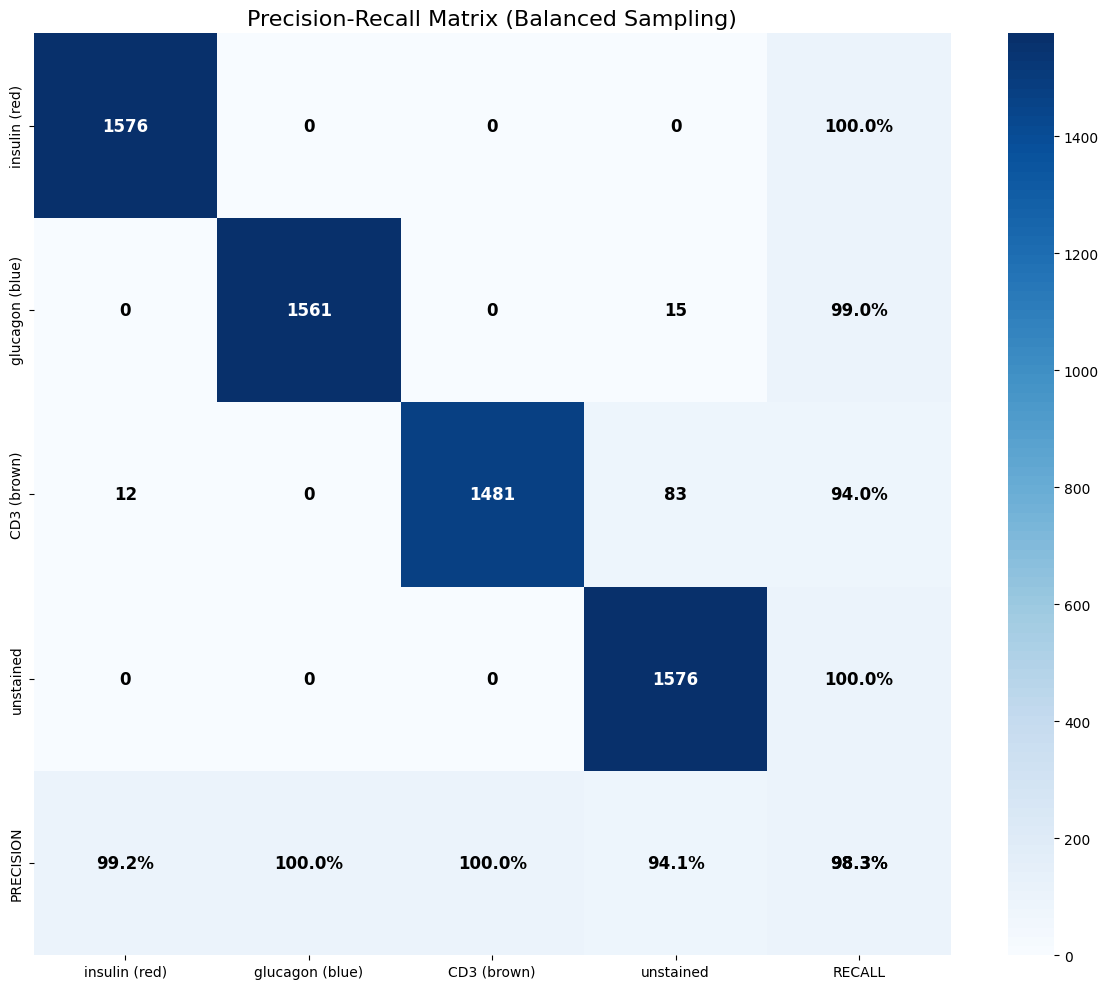

Confusion Matrix:
[[1576    0    0    0]
 [   0 1561    0   15]
 [  12    0 1481   83]
 [   0    0    0 1576]]

Precision-Recall Matrix:
[[1576.            0.            0.            0.          100.        ]
 [   0.         1561.            0.           15.           99.04822335]
 [  12.            0.         1481.           83.           93.97208122]
 [   0.            0.            0.         1576.          100.        ]
 [  99.24433249  100.          100.           94.14575866   98.25507614]]


In [205]:
import os
import numpy as np
from sklearn.metrics import confusion_matrix
from PIL import Image
import matplotlib.colors as mcolors
import seaborn as sns

def load_image(file_path):
    """Load a grayscale TIFF image using PIL."""
    with Image.open(file_path) as img:
        return np.array(img)

def load_images_from_directory(directory):
    """Load all TIFF images from a directory."""
    return [load_image(os.path.join(directory, file)) for file in sorted(os.listdir(directory)) if file.endswith('.tif')]

def sample_balanced_pixels(ground_truths, hypotheses):
    """Sample a balanced number of pixels for each class based on the class with the least pixels."""
    combined_gt = np.concatenate([gt.flatten() for gt in ground_truths])
    combined_hyp = np.concatenate([hyp.flatten() for hyp in hypotheses])

    # Count pixels for each class
    class_counts = [np.sum(combined_gt == class_value) for class_value in [1, 2, 3, 4]]

    # Find the minimum number of pixels across all classes
    min_pixels = min(class_counts)

    sampled_gt = []
    sampled_hyp = []

    for class_value in [1, 2, 3, 4]:
        class_indices = np.where(combined_gt == class_value)[0]
        if len(class_indices) <= min_pixels:
            sampled_indices = class_indices
        else:
            sampled_indices = np.random.choice(class_indices, min_pixels, replace=False)
        sampled_gt.extend(combined_gt[sampled_indices])
        sampled_hyp.extend(combined_hyp[sampled_indices])

    return np.array(sampled_gt), np.array(sampled_hyp)

def compute_confusion_matrix(y_true, y_pred):
    """Compute confusion matrix for all classes."""
    return confusion_matrix(y_true, y_pred, labels=[1, 2, 3, 4])

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def create_precision_recall_matrix(conf_matrix):
    """Create precision-recall matrix from confusion matrix."""
    class_names = ['insulin (red)', 'glucagon (blue)', 'CD3 (brown)', 'unstained']
    precision = np.diag(conf_matrix) / conf_matrix.sum(axis=0)
    recall = np.diag(conf_matrix) / conf_matrix.sum(axis=1)

    matrix = np.zeros((5, 5), dtype=float)
    matrix[:4, :4] = conf_matrix
    matrix[4, :4] = precision * 100
    matrix[:4, 4] = recall * 100

    # Calculate overall precision/recall (accuracy)
    overall_accuracy = np.sum(np.diag(conf_matrix)) / np.sum(conf_matrix)
    matrix[4, 4] = overall_accuracy * 100

    return matrix, class_names

def plot_precision_recall_matrix(matrix, class_names):
    """Plot the precision-recall matrix with a more visible color scheme."""
    plt.figure(figsize=(12, 10))

    # Create a custom colormap
    colors = ["#f7fbff", "#deebf7", "#c6dbef", "#9ecae1", "#6baed6", "#4292c6", "#2171b5", "#08519c", "#08306b"]
    n_bins = 100
    cmap = mcolors.LinearSegmentedColormap.from_list("custom_blues", colors, N=n_bins)

    # Normalize the data for color mapping
    norm = mcolors.Normalize(vmin=0, vmax=np.max(matrix[:4, :4]))

    # Create the heatmap
    ax = sns.heatmap(matrix, annot=False, cmap=cmap, norm=norm,
                     xticklabels=class_names + ['RECALL'],
                     yticklabels=class_names + ['PRECISION'],
                     cbar_kws={'format': '%.0f'})

    # Add integer annotations for confusion matrix
    for i in range(4):
        for j in range(4):
            text_color = "white" if matrix[i, j] > np.max(matrix[:4, :4]) / 2 else "black"
            ax.text(j + 0.5, i + 0.5, f'{matrix[i, j]:.0f}',
                    ha="center", va="center", color=text_color, fontweight='bold', fontsize=12)

    # Add percentage annotations for precision and recall
    for i in range(5):
        ax.text(4 + 0.5, i + 0.5, f'{matrix[i, 4]:.1f}%',
                ha="center", va="center", color="black", fontweight='bold', fontsize=12)
        if i < 4:
            ax.text(i + 0.5, 4 + 0.5, f'{matrix[4, i]:.1f}%',
                    ha="center", va="center", color="black", fontweight='bold', fontsize=12)

    # Add overall accuracy
    ax.text(4 + 0.5, 4 + 0.5, f'{matrix[4, 4]:.1f}%',
            ha="center", va="center", color="black", fontweight='bold', fontsize=12)

    plt.title('Precision-Recall Matrix (Balanced Sampling)', fontsize=16)
    plt.tight_layout()
    matrix_outpath = r"\\10.99.68.178\ashleyex\Type_1_diabetes\HE2IHC\results\inferred_IHC\plots\hsv_confusion_matrix.png"
    plt.savefig(matrix_outpath, dpi=300, bbox_inches='tight')
    plt.show()
# Directories for ground truth and hypothesis images
ground_truth_directory = r'\\10.99.68.178\ashleyex\Type_1_diabetes\HE2IHC\eval_GT_IHC\hsv_annotation\mask'
hypothesis_directory = r'\\10.99.68.178\ashleyex\Type_1_diabetes\HE2IHC\eval_GT_IHC\hsv_annotation\logicals'

# Load all images from directories
ground_truth_images = load_images_from_directory(ground_truth_directory)
hypothesis_images = load_images_from_directory(hypothesis_directory)

# Sample balanced pixels
sampled_gt, sampled_hyp = sample_balanced_pixels(ground_truth_images, hypothesis_images)

# Compute confusion matrix
conf_matrix = compute_confusion_matrix(sampled_gt, sampled_hyp)

# Create precision-recall matrix
pr_matrix, class_names = create_precision_recall_matrix(conf_matrix)

# Plot the precision-recall matrix
plot_precision_recall_matrix(pr_matrix, class_names)

# Print additional metrics
print("Confusion Matrix:")
print(conf_matrix)
print("\nPrecision-Recall Matrix:")
print(pr_matrix)

In [188]:
import matplotlib.pyplot as plt
# pixel area correlation
gt_path = r"\\10.99.68.178\ashleyex\Type_1_diabetes\HE2IHC\results\inferred_IHC\GT_IHC_hsv\logicals"
synthetic_paths = [r"\\10.99.68.178\ashleyex\Type_1_diabetes\HE2IHC\results\inferred_IHC\iter_1510_hsv\logicals",
                   r"\\10.99.68.178\ashleyex\Type_1_diabetes\HE2IHC\results\inferred_IHC\iter_3020_hsv\logicals" ,
                   r"\\10.99.68.178\ashleyex\Type_1_diabetes\HE2IHC\results\inferred_IHC\iter_4530_hsv\logicals",
                   r"\\10.99.68.178\ashleyex\Type_1_diabetes\HE2IHC\results\inferred_IHC\iter_6040_hsv\logicals",
                    r"\\10.99.68.178\ashleyex\Type_1_diabetes\HE2IHC\results\inferred_IHC\iter_7550_hsv\logicals",
                   r"\\10.99.68.178\ashleyex\Type_1_diabetes\HE2IHC\results\inferred_IHC\iter_9060_hsv\logicals",
                   r"\\10.99.68.178\ashleyex\Type_1_diabetes\HE2IHC\results\inferred_IHC\iter_10570_hsv\logicals",
                   r"\\10.99.68.178\ashleyex\Type_1_diabetes\HE2IHC\results\inferred_IHC\iter_12080_hsv\logicals",
                   r"\\10.99.68.178\ashleyex\Type_1_diabetes\HE2IHC\results\inferred_IHC\iter_13590_hsv\logicals",
                   r"\\10.99.68.178\ashleyex\Type_1_diabetes\HE2IHC\results\inferred_IHC\iter_15100_hsv\logicals",]
only_files = [f for f in listdir(gt_path) if isfile(join(gt_path, f))]

x = list(range(1, len(only_files) + 1))
y_coords = [[],[],[],[],[],[],[],[],[],[]]
index = 0
for syn_path in synthetic_paths:
    for read_path in only_files:
        final_gt_path = join(gt_path, read_path)
        final_synthetic_path = join(syn_path, read_path.replace('.png', '_inferred.png'))
        #print(f"Processing {final_synthetic_path}")  # Debugging line to print the file path being processed
        gt_img = cv2.imread(final_gt_path, cv2.IMREAD_GRAYSCALE)
        syn_img = cv2.imread(final_synthetic_path, cv2.IMREAD_GRAYSCALE)
        gt_pixel_count = np.count_nonzero(gt_img == 2)
        syn_pixel_count = np.count_nonzero(syn_img == 2)
        difference = gt_pixel_count - syn_pixel_count
        #print("index ", index, " ", difference)
        y_coords[index].append(difference)
    index = index + 1




[[-11657, 819, -2946, 1715, -532, -104, 740, 13, 479, 269, 1671, -207, 143, -2365, -32, 1924, 2007, 503, -15, 948, 439, 2037, 725, 922, 812, -803, -10138, 673, -7, 175, -409, 0, -2581, -1174, -311, 761, -5516, 435, 357, 68, 604, -450, 433, 760, 410, 97, 1373, 221, 98, 645, 166, -238, 691, 546, -99, 278, 1223, 28, -34, -278, -1107, 1020, -2825, 80, -669, -12018, -227, -169, -5039, -2052, -3269, -1827, 560, 363, -861, -658, 473, 985, -3959, -1858, 340, -3203, -3248, 856, -2247, -490, -9308, -794, -9423, -8941, -1798, -2484, -4266, -6261, -4906, -476, -128, -181, -6731, -5010, 1203, -684, -30, -869, -3, -400, 209, -6538, -3906, -2712, -2060, -3384, -4258, 680, 1153, 1576, 961, -11347, -7759, 1575, -6268, -1822, 3047, -204, -7342, -566, 1694, 1605, 1641, -4661, -625, 2387, -6736, -3162, -3651, -4626, -764, 185, -2711, -53, 269, -1422, 27, 238, 116, -831, 723, 3136, -51, -242, 2257, 2437, -2684, 1717, -1066, 496, 12, 130, 888, 2756, -1185, -1261, -476, -69, 3, -1062, -555, -1491, -499, 636,

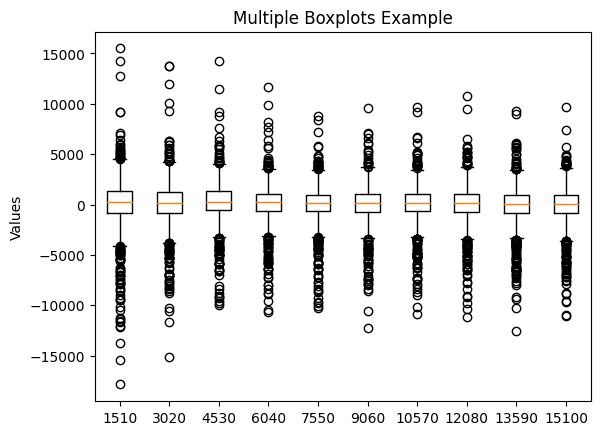

In [189]:
print(y_coords)
# Creating the boxplot
plt.boxplot(y_coords, labels=['1510', '3020', '4530', '6040', '7550', '9060', '10570', '12080', '13590', '15100'])
#plt.yscale('symlog', linthresh=1)
# Adding title and labels
plt.title("Multiple Boxplots Example")
plt.ylabel("Values")

# Show plot
plt.show()

In [190]:

import matplotlib.pyplot as plt
# pixel area correlation
gt_path = r"\\10.99.68.178\ashleyex\Type_1_diabetes\HE2IHC\results\inferred_IHC\GT_IHC_hsv\logicals"
synthetic_paths = [r"\\10.99.68.178\ashleyex\Type_1_diabetes\HE2IHC\results\inferred_IHC\iter_1510_hsv\logicals",
                   r"\\10.99.68.178\ashleyex\Type_1_diabetes\HE2IHC\results\inferred_IHC\iter_3020_hsv\logicals" ,
                   r"\\10.99.68.178\ashleyex\Type_1_diabetes\HE2IHC\results\inferred_IHC\iter_4530_hsv\logicals",
                   r"\\10.99.68.178\ashleyex\Type_1_diabetes\HE2IHC\results\inferred_IHC\iter_6040_hsv\logicals",
                   r"\\10.99.68.178\ashleyex\Type_1_diabetes\HE2IHC\results\inferred_IHC\iter_7550_hsv\logicals",
                   r"\\10.99.68.178\ashleyex\Type_1_diabetes\HE2IHC\results\inferred_IHC\iter_9060_hsv\logicals",
                   r"\\10.99.68.178\ashleyex\Type_1_diabetes\HE2IHC\results\inferred_IHC\iter_10570_hsv\logicals",
                   r"\\10.99.68.178\ashleyex\Type_1_diabetes\HE2IHC\results\inferred_IHC\iter_12080_hsv\logicals",
                   r"\\10.99.68.178\ashleyex\Type_1_diabetes\HE2IHC\results\inferred_IHC\iter_13590_hsv\logicals",
                   r"\\10.99.68.178\ashleyex\Type_1_diabetes\HE2IHC\results\inferred_IHC\iter_15100_hsv\logicals",]
only_files = [f for f in listdir(gt_path) if isfile(join(gt_path, f))]

x = list(range(1, len(only_files) + 1))
y_coords = [[],[],[],[],[],[],[],[],[],[],[]]
index = 0
for read_path in only_files:
    final_path = join(gt_path, read_path)
    #print(f"Processing {final_path}")  # Debugging line to print the file path being processed
    gt_img = cv2.imread(final_path)
    gt_pixel_count = np.count_nonzero(gt_img == 3)
    height, width, channels = gt_img.shape
    composition = gt_pixel_count / (height * width * channels)
    #print("syn_pixel_count ", syn_pixel_count, " composition ", composition)
    #print("index ", index, " ", difference)
    y_coords[index].append(composition)
index = 1
for syn_path in synthetic_paths:
    subindex = 0
    for read_path in only_files:
        final_path = join(syn_path, read_path.replace('.png', '_inferred.png'))
        #print(f"Processing {final_path}")  # Debugging line to print the file path being processed
        syn_img = cv2.imread(final_path)
        syn_pixel_count = np.count_nonzero(syn_img == 3)
        height, width, channels = syn_img.shape
        composition = syn_pixel_count / (height * width * channels)
        composition_difference = y_coords[0][subindex] - composition
        #print("syn_pixel_count ", syn_pixel_count, " composition ", composition)
        #print("index ", index, " ", difference)
        y_coords[index].append(composition_difference)
        subindex = subindex + 1
    index = index + 1


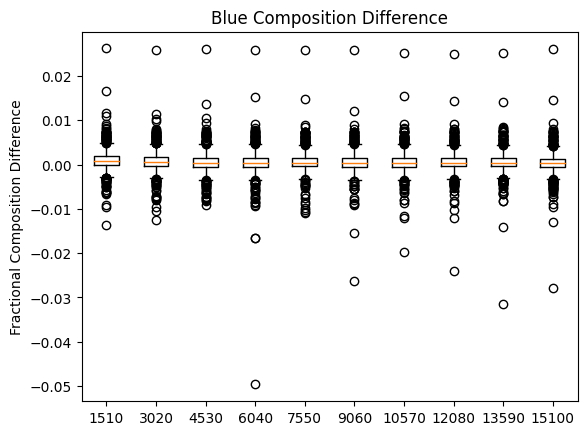

In [191]:
# Creating the boxplot
y_coords = y_coords[1:]
plt.boxplot(y_coords, labels=['1510', '3020', '4530', '6040', '7550', '9060', '10570', '12080', '13590', '15100'])
#plt.yscale('symlog', linthresh=1)
# Adding title and labels
plt.title("Blue Composition Difference")
plt.ylabel("Fractional Composition Difference")

# Show plot
plt.show()